**Task: the model should predict the hotel rating according to the Booking website based on the data available in the dataset. The intelligence analysis skills we've learned will help improve the model.***

In [154]:
pip install iso3166

Note: you may need to restart the kernel to use updated packages.


In [155]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


**Libraries instalation.**

In [156]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
# инструмент для создания и обучения модели  
from sklearn.ensemble import RandomForestRegressor 
# инструменты для оценки точности модели  
from sklearn import metrics 
# хи-квадрат.
from sklearn.feature_selection import chi2 
# anova
from sklearn.feature_selection import f_classif 
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
#библиотека для работы с координатами
from geopy.geocoders import Nominatim
import re
#библиотека кодировщиков
import category_encoders as ce
import warnings
from pandas.errors import SettingWithCopyWarning
from iso3166 import countries

In [157]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы.
!pip freeze > requirements.txt
# Игнорируем предупреждения
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

**Downloading data**

In [158]:
# загрузка данных из соревнования
# датасет для обучения
df_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')
# датасет для предсказания                    
df_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv') 
# самбмишн
sample_submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv') 

**Getting to know the data**

In [159]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [160]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [161]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [162]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [163]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


**Data cleaning&filling and new features creation.**

In [164]:
#зачищаем дубликаты в df_train
#df_train = df_train.drop_duplicates()

In [165]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет.
df_train['sample'] = 1 # помечаем, где у нас трейн
df_test['sample'] = 0 # помечаем, где у нас тест
df_test.insert(12, 'reviewer_score', 0) # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
#соединим обе части для единой обработки
df_test['reviewer_score'] = 0
raw_hotels =pd.concat([df_train, df_test],ignore_index=True,axis=0)

In [166]:
raw_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [167]:
#Найдем пропущенные координаты и заполним их с помощью geopy.geocoders
geolocator = Nominatim(user_agent="lvn")

raw_hotels[['lat','lng']] = raw_hotels[['lat','lng']].fillna(0)
mask = ((raw_hotels['lat'] == 0) | (raw_hotels['lng'] == 0))
hotel_none = raw_hotels[mask]
hotel_list = hotel_none.hotel_name.value_counts().index.to_list()
hotel_adr = hotel_none.hotel_address.value_counts().index.to_list()
place_list = dict
for h,a in zip(hotel_list, hotel_adr):
    place = geolocator.geocode(h, exactly_one=True, language='en',timeout=None) 
    if place == None: 
        a = a.split(' ')[-4:]
        a = ' '.join(a)
        place = geolocator.geocode(a, exactly_one=True, language='en',timeout=None)
        raw_hotels.loc[raw_hotels['hotel_name'].eq(h),'hotel_address'] = place.address
    raw_hotels.loc[raw_hotels['hotel_name'].eq(h) & raw_hotels['lat'].eq(0), 'lat'] = place.latitude
    raw_hotels.loc[raw_hotels['hotel_name'].eq(h) & raw_hotels['lng'].eq(0), 'lng'] = place.longitude

In [168]:
#выделим страну из строки адреса
raw_hotels['country'] = raw_hotels['hotel_address'].str.split(' ')
#функция выделяет страну из строки адреса
def country_extraction(words):
    raw_country = []
    for word in words: 
        if word.isalpha() == True: 
            raw_country.append(word)
    if raw_country[-1] in countries: 
        country = raw_country[-1]
        return country
    else: 
        country = raw_country[-2]+' '+raw_country[-1]
        return country
raw_hotels['country'] =raw_hotels['country'].apply(country_extraction)

In [169]:
"""#т.к. для каждого отеля координаты одинаковы, то подойдет любая функция не меняющая их.
h_coor_list = raw_hotels.groupby('hotel_name').min()[['lat','lng']]
h_coor_list['cc'] = list(zip(h_coor_list['lat'],h_coor_list['lng']))
h_coor_list = h_coor_list.drop(['lat','lng'],axis=1)
h_coor_list
coors = h_coor_list.cc.value_counts().index.to_list()
#places = []
for coor in coors:
    place = geolocator.reverse(coor, exactly_one=True, language='en',timeout=None) 
    places.append(place)"""

"#т.к. для каждого отеля координаты одинаковы, то подойдет любая функция не меняющая их.\nh_coor_list = raw_hotels.groupby('hotel_name').min()[['lat','lng']]\nh_coor_list['cc'] = list(zip(h_coor_list['lat'],h_coor_list['lng']))\nh_coor_list = h_coor_list.drop(['lat','lng'],axis=1)\nh_coor_list\ncoors = h_coor_list.cc.value_counts().index.to_list()\n#places = []\nfor coor in coors:\n    place = geolocator.reverse(coor, exactly_one=True, language='en',timeout=None) \n    places.append(place)"

In [170]:
#Уточним кол-во слов во всех отзывах с учетом опозитных.
raw_hotels['negative_review'] = raw_hotels['negative_review'].str.lower().str.strip()
raw_hotels['positive_review'] = raw_hotels['positive_review'].str.lower().str.strip()

np_list = ['no positive', 'nothing', '', 'no', 'noise', 'non','none','nothing not to like']
nn_list = ['no negative', 'nothing', 'n a', 'none', '', 'nothing really','all good',
 'no complaints', 'nothing at all', 'nothing to dislike', 'nil', 'everything was perfect',
 'na', 'can t think of anything', 'nothing to complain about', 'nothing not to like',
 'nothing all good', 'i liked everything', 'everything was good',  'nothing it was perfect',
 'non', 'nothing everything was perfect', 'liked everything', 'nothing in particular',
 'everything was fine', 'nothing everything was great', 'not applicable', 'all was good',
 'no', 'nothing comes to mind', 'there was nothing i didn t like', 'not a thing',
 'nothing i didn t like', 'no complaints at all', 'no negatives', 'we liked everything',
 'no thing', 'nothing to report', 'all ok', 'there was nothing to dislike', 'loved everything',
 'the weather',  'nothing i can think of', 'nothing to say', 'no dislikes', 'no bad experience',
 'nothing to mention',  'nothing to complain', 'no issues', 'there was nothing not to like',
'no comment', 'everything was ok', 'everything was excellent','no problems',
 'nada', 'nothing we didn t like', 'nothing special','couldn t fault it','going home',
 'nothing bad to say', 'nothing bad', 'i loved everything', 'no comments',
 'liked it all','nothing could have been better',  'nothing to not like',
 'all great','nothing it was all good', 'it was perfect',
 'nothing it was great', 'there wasn t anything we didn t like','nothing to fault',
'what s not to like','loved it all', 'cannot think of anything', 'no bad experiences',
'i have no complaints','i liked it all']

#функция сверяет смысловую нагрузку с исключениями и возвращает кол-во слов в отзыве.
def opposit(item,fixed):
    if item in fixed:
        return 0
    else:
        return len(item.split(' '))

raw_hotels['review_total_negative_word_counts'] = raw_hotels['negative_review'].apply(lambda qty:opposit(qty,nn_list))
raw_hotels['review_total_positive_word_counts'] = raw_hotels['positive_review'].apply(lambda qty:opposit(qty,np_list))
#Удалим невостребованные данные.
raw_hotels = raw_hotels.drop(['negative_review','positive_review'], axis=1)


In [171]:
#удалим пустые отзывы с оценкой для части трейн
mask = raw_hotels[(raw_hotels['review_total_negative_word_counts'] == 0) & \
                  (raw_hotels['review_total_positive_word_counts'] == 0) & \
                  (raw_hotels['sample'] == 1)].index.to_list()
raw_hotels = raw_hotels.drop(index = mask)

In [172]:
#Выделим месяц и год из даты отзыва.
raw_hotels['review_dayofweek'] = pd.to_datetime(raw_hotels['review_date']).dt.dayofweek
raw_hotels['review_month'] = pd.to_datetime(raw_hotels['review_date']).dt.month
raw_hotels['review_year'] = pd.to_datetime(raw_hotels['review_date']).dt.year
#Удалим невостребованные данные.
raw_hotels = raw_hotels.drop(['review_date'],axis=1)

In [173]:
#В признаке days_since_review оставим только кол-во дней в числовом типе данных.
raw_hotels['days_since_review'] = raw_hotels['days_since_review'].str.split(' ')
raw_hotels['days_since_review'] = raw_hotels['days_since_review'].str[0]
raw_hotels['days_since_review'] = raw_hotels['days_since_review'].astype(int)

In [174]:
#приведем теги к единому регистру и сохраним в виде списка.
raw_hotels['tags_list'] = raw_hotels['tags'].str.lower().str.findall("'[^\'](.+?)[^\']'")
#Из тегов создадим новые признаки кол-ва ночей, кол-ва гостей, вид путешествия, 
#вид номера отеля, способ подтверждения размещения.
def details(tag_list):
    details_set = ['not defined','not defined','not defined','not defined','others']
    for t in tag_list:
        if 'loft' in t or 'maisonette' in t or 'queen bed' in t or 'apartment' in t or 'king' in t or 'standard' in t or 'room' in t or 'suite' in t or 'studio' in t or 'double' in t or 'superior' in t or 'deluxe' in t: 
            details_set[0] = t 
        elif 'night' in t: 
            details_set[1] = t 
        elif 'couple' in t or 'traveler' in t or 'children' in t or 'group' in t:
            details_set[2] = t
        elif 'trip' in t:
            details_set[3] = t
        elif 'submit' in t:
            details_set[4] = t
    return details_set

raw_hotels['room'], raw_hotels['night'], raw_hotels['people'], raw_hotels['trip'], \
raw_hotels['assignment'] = zip(*raw_hotels['tags_list'].map(details))

def cleaner(pack, elem):
    if elem in pack:
        pack.remove(elem)
        return pack
    else: return pack
raw_hotels['tags_list'] = list(map(cleaner,raw_hotels['tags_list'],raw_hotels['room']))
raw_hotels['tags_list'] = list(map(cleaner,raw_hotels['tags_list'],raw_hotels['night']))
raw_hotels['tags_list'] = list(map(cleaner,raw_hotels['tags_list'],raw_hotels['people']))
raw_hotels['tags_list'] = list(map(cleaner,raw_hotels['tags_list'],raw_hotels['trip']))
raw_hotels['tags_list'] = list(map(cleaner,raw_hotels['tags_list'],raw_hotels['assignment']))
#Удалим невостребованные данные.
raw_hotels = raw_hotels.drop(['tags','tags_list'], axis=1)

In [175]:
#Выделим значимую часть для признаков reviewer_nationality, room.  
#Остальную часть обозанчим как 'others'
raw_hotels['reviewer_nationality'] = raw_hotels['reviewer_nationality'].str.strip()
nations = pd.DataFrame(raw_hotels['reviewer_nationality'].value_counts(normalize=True))
accomod = pd.DataFrame(raw_hotels['room'].value_counts(normalize=True))
#функция относит значения признаков с представлением менее 0,5% в 'Others'
def other(meaning):
    if meaning in others: return 'Others'
    else : return meaning
others = nations[nations.proportion < 0.005]['proportion'].index.to_list()
raw_hotels['reviewer_nationality'] = raw_hotels['reviewer_nationality'].apply(other)
#display(raw_hotels['reviewer_nationality'].value_counts(normalize=True))
others = accomod[accomod.proportion < 0.005]['proportion'].index.to_list()
raw_hotels['room'] = raw_hotels['room'].apply(other)
#display(raw_hotels['room'].value_counts(normalize=True))

**Categorical features encoding.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Positive/negative word counts')

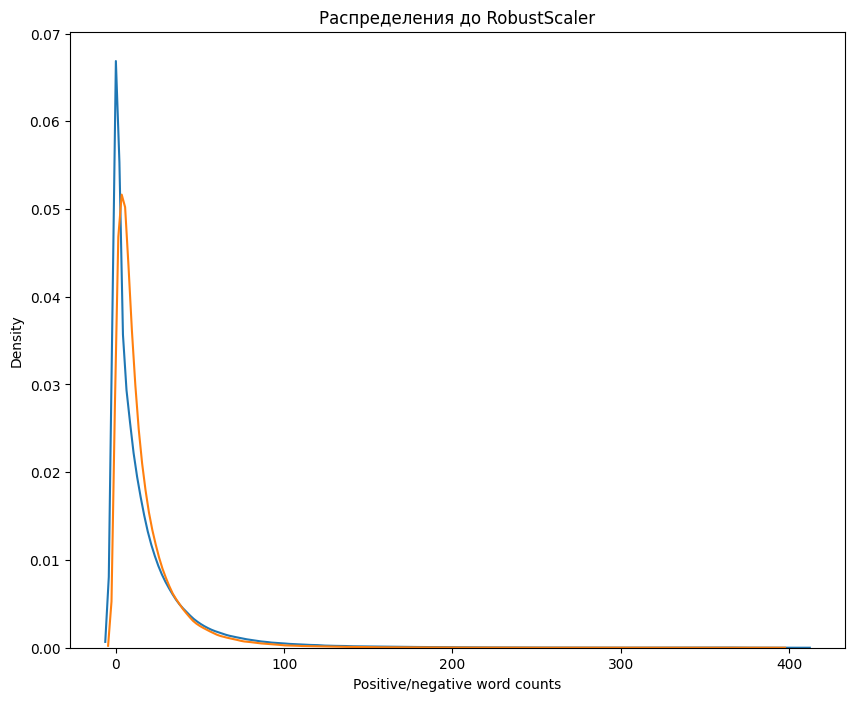

In [176]:
#визуализируем распределение признаков кол-ва слов в положительном и отрицательном отзывах 
#до нормализации RobustScaler
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения до RobustScaler')

sns.kdeplot(raw_hotels['review_total_negative_word_counts'], ax=ax1)
sns.kdeplot(raw_hotels['review_total_positive_word_counts'], ax=ax1)
plt.xlabel('Positive/negative word counts', fontsize=10)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Positive/negative word counts')

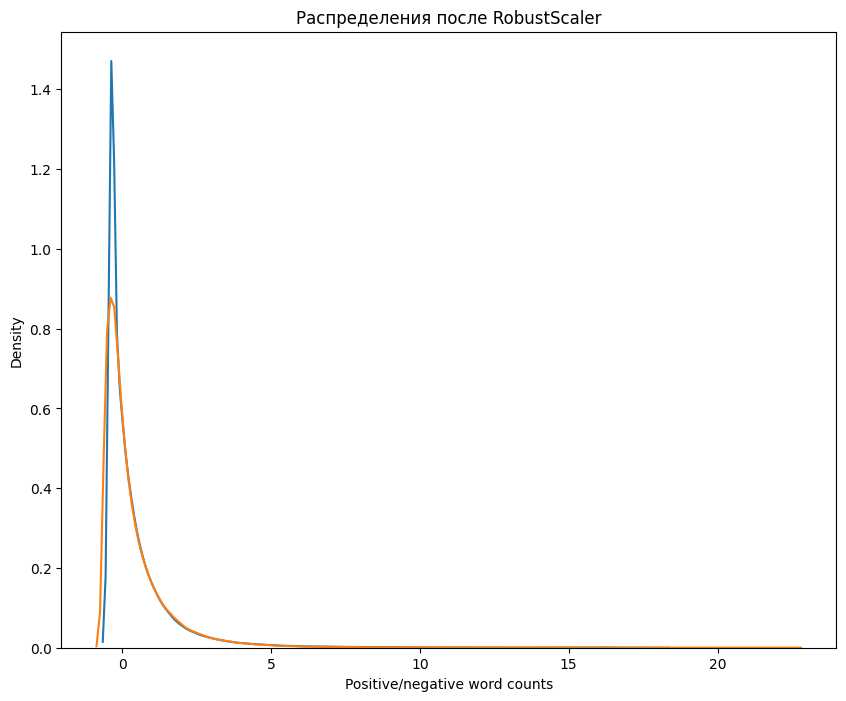

In [177]:
copied_df = raw_hotels.copy()
col_names = ['review_total_negative_word_counts', 'review_total_positive_word_counts']
features = copied_df[col_names]
scaler = RobustScaler().fit(features.values)
features = scaler.transform(features.values)
copied_df[col_names] = features
#copied_df.head(2)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
raw_hotels = copied_df
#визуализируем распределение признаков кол-ва слов в положительном и отрицательном отзывах 
#после нормализации RobustScaler
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(raw_hotels['review_total_negative_word_counts'], ax=ax1)
sns.kdeplot(raw_hotels['review_total_positive_word_counts'], ax=ax1)
plt.xlabel('Positive/negative word counts', fontsize=10)

In [178]:
# Используем OneHotEncoder для кодирования признаков с общим кол-вом < 15
encoder = ce.OneHotEncoder(cols=['country','people', 'trip', 'assignment'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(raw_hotels[['country','people', 'trip', 'assignment']])
raw_hotels = pd.DataFrame(pd.concat([raw_hotels, type_bin], axis=1))

In [179]:
# создаем объект OrdinalEncoder
enc = ce.OrdinalEncoder()
# применяем трансформацию к столбцу
data_bin = enc.fit_transform(raw_hotels['room'])
# добавляем результат к исходному DataFrame
raw_hotels = pd.concat([raw_hotels, data_bin], axis=1)
raw_hotels = raw_hotels.drop(['room'],axis=1)

In [180]:
# Используем BinaryEncoder для кодирования признаков с общим кол-вом > 15
bin_encoder = ce.BinaryEncoder(cols=['night','reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(raw_hotels[['night','reviewer_nationality']])
raw_hotels = pd.concat([raw_hotels, type_bin], axis=1)

In [ ]:
#С помощью тепловой карты визуализируем корреляция числовых признаков
temp = raw_hotels[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',\
                  'total_number_of_reviews', 'review_total_positive_word_counts', \
                    'total_number_of_reviews_reviewer_has_given', 'reviewer_score',\
                  'lat', 'lng', 'review_dayofweek','review_month', 'review_year','days_since_review']]
sns.heatmap(temp.corr(), annot=True) # включаем отображение коэффициентов

<Axes: >

In [182]:
#Удалим по одному признаку из пары, где коэффициент корреляции +/-0.7 и выше
#raw_hotels = raw_hotels.drop(['additional_number_of_scoring','days_since_review'], axis=1)

**Preporation for ML.**

In [183]:
#Удалим не числовые признаки датафрейма
object_columns = [s for s in raw_hotels.columns if raw_hotels[s].dtypes == 'object']
raw_hotels.drop(object_columns, axis = 1, inplace=True)

In [184]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
train_data = raw_hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = raw_hotels.query('sample == 0').drop(['sample'], axis=1)

**ML execution.**

In [185]:
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
y = train_data.reviewer_score.values # наша цель
X = train_data.drop(['reviewer_score'], axis=1)
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [186]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 41), (386425, 41), (386425, 40), (309140, 40), (77285, 40))

In [187]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [188]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13299636214932758


**Model testing and results submissioning.**

In [189]:
predict_submission = regr.predict(test_data)

In [190]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.695,488440
1,7.474,274649
2,8.012,374688
3,9.646,404352
4,9.582,451596
5,8.682,302161
6,7.507,317079
7,7.898,13963
8,8.233,159785
9,7.811,195089
